# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from libs.dataset import *
import torch
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from libs.networks.vgg_refinedet import VGGRefineDet

/root/workspace/pytorch_proj/proj/pytorch_refinedet/libs/networks/refinedet.py:201: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (len(self.layers_out_channels) == len(self.cfg['mbox']),


## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (21 for VOC dataset)
2. Next we load pretrained weights on the VOC0712 trainval dataset  

In [2]:
from libs.dataset import VOC_CLASSES as labels
net = VGGRefineDet(voc['num_classes'], voc)    # initialize SSD
net.create_architecture()
net.eval()
net = net.cuda()
# load weights
weights_path = '../weights/refinedet320_VOC_60000.pth'
weights = torch.load(weights_path)
net.load_state_dict(weights)

Initializing weights...


## Load Image 
### Here we just load a sample image from the VOC07 dataset 

/root/dataset/voc/VOCdevkit/VOC2007


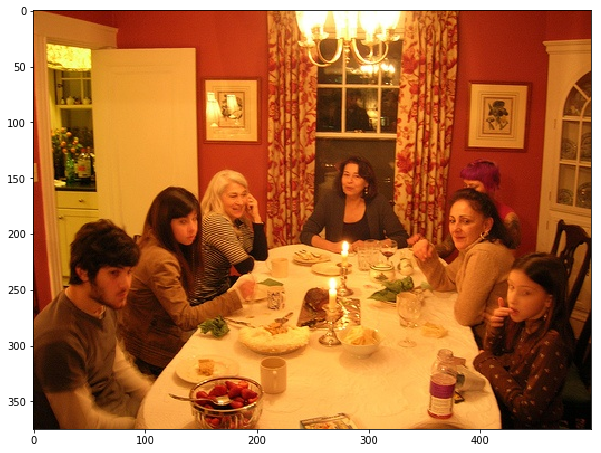

In [3]:
# image = cv2.imread('./data/example.jpg', cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded
%matplotlib inline
from matplotlib import pyplot as plt
from libs.dataset import VOCDetection, VOC_ROOT, VOCAnnotationTransform
import pdb
# here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
testset = VOCDetection(VOC_ROOT, [('2007', 'val')], None, VOCAnnotationTransform())
# img_id = 60
img_id = 60
image = testset.pull_image(img_id)
# pdb.set_trace()
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

## Pre-process the input.  
#### Using the torchvision package, we can create a Compose of multiple built-in transorm ops to apply 
For SSD, at test time we use a custom BaseTransform callable to
resize our image to 300x300, subtract the dataset's mean rgb values, 
and swap the color channels for input to SSD300.

In [4]:
x = cv2.resize(image, (320, 320)).astype(np.float32)

# import pdb
# pdb.set_trace()
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
# plt.imshow(x / 255.0)
x = torch.from_numpy(x).permute(2, 0, 1)

## SSD Forward Pass
### Now just wrap the image in a Variable so it is recognized by PyTorch autograd

In [5]:
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)

## Parse the Detections and View Results
Filter outputs with confidence scores lower than a threshold 
Here we choose 60% 

torch.Size([1, 21, 200, 5])
20
25


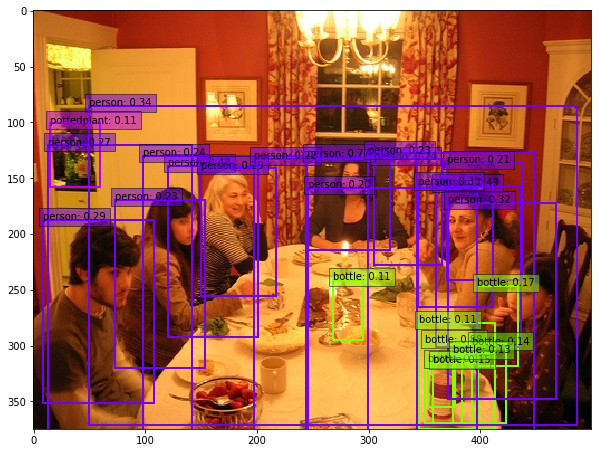

In [6]:

top_k=10
num_classes = len(labels)
# num_classes = 1
plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, num_classes+1)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y
print(detections.size())
print(len(labels))
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
sum_j = 0
for i in range(1, detections.size(1)):
# for i in range(0, 1):
    j = 0
    while detections[0,i,j,0] >= 0.1:
        score = detections[0,i,j,0]
#         print(score)
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
#         print(pt)
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1
    sum_j += j
    
print(sum_j)